# Country Guessing Game

In [ ]:
pip install gradio

### Classifier

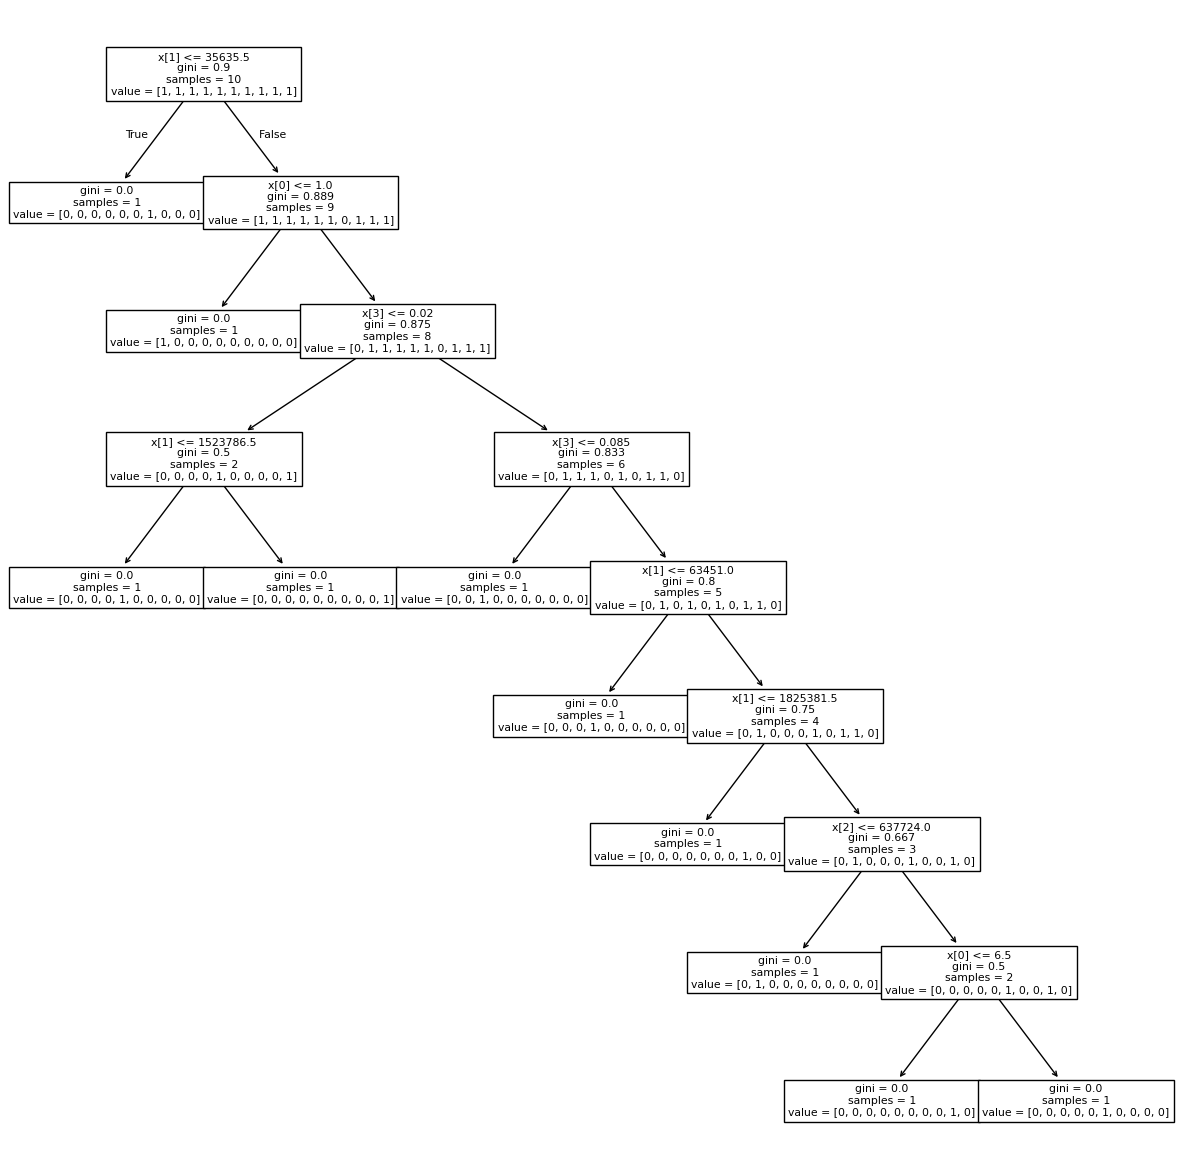

In [24]:
from sklearn import tree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("countries.csv")

# make data useable
df["Country"] = df["Country"].astype(str).str.strip()
df["Region"] = df["Region"].astype(str).str.strip().str.upper()


# Label encoding für das Ziel (Y) und Region
le_country = LabelEncoder()
df["Country"] = le_country.fit_transform(df["Country"])


le_region = LabelEncoder()
df["Region"] = le_region.fit_transform(df["Region"])


for col in ["Population", "Area (sq. mi.)", "Coastline (coast/area ratio)"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )


# Features und Ziel setzen
feature_columns = [
    "Region",
    "Population",
    "Area (sq. mi.)",
    "Coastline (coast/area ratio)"
]

# X (input) => Feature values such as population range continent, etc.
# each element of array is to be a fact of the country (e.g. "80'000'000 => population of germany")
X = df[feature_columns].iloc[:10].values

# Y (output) => country which the element of X refers to
# for the above example => "germany"
Y = df["Country"].iloc[:10].values

# Decision Tree trainieren
clf = tree.DecisionTreeClassifier()
clf.fit(X, Y)
plt.figure(figsize=(15, 15))  # Adjust the

tree.plot_tree(clf)
plt.show()

In [10]:
clf.get_n_leaves()
clf.get_depth()

42

### Prediction based on hard coded input

In [ ]:
# prediction based on input
region_example = le_region.transform(["WESTERN EUROPE"])[0]
example = [[region_example, 83000000, 357000, 0.34]]
predicted = clf.predict(example)
predicted_country = le_country.inverse_transform(predicted)

predicted_country


array(['Finland'], dtype=object)

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import gradio as gr
from sklearn.tree import _tree

df = pd.read_csv("countries.csv")
df["Country"] = df["Country"].astype(str).str.strip()
df["Region"] = df["Region"].astype(str).str.strip().str.upper()

le_country = LabelEncoder()
df["Country"] = le_country.fit_transform(df["Country"])

le_region = LabelEncoder()
df["Region"] = le_region.fit_transform(df["Region"])

for col in ["Population", "Area (sq. mi.)", "Coastline (coast/area ratio)"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

feature_columns = [
    "Region",
    "Population",
    "Area (sq. mi.)",
    "Coastline (coast/area ratio)"
]

X = df[feature_columns].values
Y = df["Country"].values

clf = tree.DecisionTreeClassifier()
clf.fit(X, Y)

class AkinatorSession:
    def __init__(self, clf, feature_names, le_country, le_region):
        self.clf = clf
        self.tree = clf.tree_
        self.feature_names = feature_names
        self.le_country = le_country
        self.le_region = le_region
        self.node = 0
        self.finished = False
        self.prediction = None

    def make_question(self):
        feature_index = self.tree.feature[self.node]
        threshold = self.tree.threshold[self.node]
        feature_name = self.feature_names[feature_index]

        if feature_name == "Region":
            region_index = int(threshold + 0.5)  # runden für genaue Zuordnung
            try:
                region_name = self.le_region.inverse_transform([region_index])[0]
                return f"Ist dein Land in der Region '{region_name}'?"
            except:
                return f"Liegt dein Land in einer Region mit Index ≤ {region_index}?"
        else:
            return f"Ist '{feature_name}' ≤ {round(threshold, 2)}?"

    def answer(self, response):
        if self.finished:
            return "Das Spiel ist vorbei."

        if response == "Ja":
            self.node = self.tree.children_left[self.node]
        else:
            self.node = self.tree.children_right[self.node]

        if self.tree.feature[self.node] == _tree.TREE_UNDEFINED:
            class_index = self.tree.value[self.node].argmax()
            self.prediction = self.le_country.inverse_transform([class_index])[0]
            self.finished = True
            return f"Ich denke, dein Land ist: {self.prediction.strip()}"
        else:
            return self.make_question()

session = AkinatorSession(clf, feature_columns, le_country, le_region)

# Gradio UI
def play_game(response):
    return session.answer(response)

with gr.Blocks() as demo:
    gr.Markdown("# MaGa-Länder-Akinator")
    question = gr.Textbox(value=session.make_question(), label="Frage", interactive=False)
    output = gr.Textbox(label="Antwort der KI", interactive=False)
    with gr.Row():
        yes_btn = gr.Button("Ja")
        no_btn = gr.Button("Nein")

    def on_yes():
        result = play_game("Ja")
        question.value = result if not session.finished else ""
        return result

    def on_no():
        result = play_game("Nein")
        question.value = result if not session.finished else ""
        return result

    yes_btn.click(fn=on_yes, outputs=output)
    no_btn.click(fn=on_no, outputs=output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dd16b69cddbdbcefd1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
